# Kaggle Competition - Santander Customer Satisfaction
---

## Abstract

We will have a detailed look into the Kaggle Competition - Santander Customer Satisfaction, here the aim of the competition is to identify the dissatisfied customers based on various factors given in the data set. All the features have been anonymized. The problem at hand is a classification problem i.e to identify if a customer is satisfied or dissatisfied. And the competition requires us to output the probablity that a customer would be dissatisfied. Evaluation critaria is `Area under the ROC.` 

At an initial glance at the data set we can see that the data has 369 feature columns and one target column. So we will perform a Principle component analysis for reducing the dimension of the dataset. We will also perform feature selection and hyperparameter tuning for the model. As the dataset has multiple features a tree based model will be a good option.

Once the model is created we will create a submission file for uploading to Kaggle.

## Index

1. [Importing libraries](#Importing-libraries)
2. [Loading data](#Loading-data)
3. [Performing Principle Component Analysis](#Performing-Principle-Component-Analysis)
4. [Performing Feature Selections](#Performing-Feature-Selections)
5. [Hyper Parameter Tuning](#Hyper-Parameter-Tuning)
6. [Preparing submission file](#Preparing-submission-file)
7. [Conclusion](#Conclusion)
8. [Contributions](#Contributions)
9. [Citations](#Citations)
10. [License](#License)

### Importing libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

### Loading data

In [2]:
df = pd.read_csv("./train.csv",index_col=0)
df.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
ID,,,,,,,,,,,,,,,,,,,,,
1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


Initializing feature and target colums

In [3]:
X = df.drop(['TARGET'],axis = 1)
y = df.TARGET.values

In [4]:
def train_xgb(X,y,n_estimators, max_depth,num_parallel_tree,gamma,min_child_weight,subsample):
    """
        This function runs XGB model with CV and gives the score in AUC. 
    """
    kfold = StratifiedKFold(n_splits=5, random_state=1)
    xgb_model = xgb.XGBClassifier(n_estimators=n_estimators,nthread=-1, 
                                  max_depth = max_depth,seed=1,
                                  num_parallel_tree=num_parallel_tree,gamma=gamma,min_child_weight=min_child_weight,
                                  subsample=subsample)    
    score = cross_val_score(xgb_model, X, y, cv=kfold, scoring= 'roc_auc',n_jobs =2, verbose= 1)
    return score

Generating base model with all the features 

In [5]:
score = train_xgb(X,y,n_estimators=110, max_depth = 4, num_parallel_tree = 2,
          gamma=0.99,min_child_weight=2,subsample = 0.6)


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  5.2min finished


In [6]:
print(score.mean())

0.8389457526022358


##### Observation:
* The model with all the 369 columns gives us a model with AUC as 0.83895
* But this model contains some features with a lot of variance and some features are redundent.

### Performing Principle Component Analysis

Performing PCA to reduce the dimension as there are 369 features and not all of them are required

Firstly Standardizing the features so that the features are ready for PCA 

In [7]:
standardized_X = StandardScaler().fit_transform(X)

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\PC\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Performing PCA fit and transform to reduce the feature space

In [8]:
pca = PCA(0.95)
pca_X = pca.fit_transform(standardized_X)
pca_X.shape

(76020, 100)

Cross validating model

In [9]:
score = train_xgb(pca_X,y,n_estimators=110, max_depth = 4, num_parallel_tree = 2,
          gamma=0.99,min_child_weight=2,subsample = 0.6)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.1min finished


In [10]:
print(score.mean())

0.8255822268470425


##### Observations:
* The dimension is now reduced to 100 features
* But the AUC has also decreased to 0.82558
* Need to perform Feature selection instead

### Performing Feature Selections

Removing features with variance less than threshold

In [11]:
def removeFeaturesWithVarThres(thresh, X_data):
    constant_filter = VarianceThreshold(threshold=(thresh*(1-thresh)))  
    constant_filter.fit(X_data)
    constant_columns = [column for column in X_data.columns if column not in X_data.columns[constant_filter.get_support()]]
    copy = X_data[:]
    copy.drop(labels=constant_columns, axis=1, inplace=True)
    return copy

Variance thresold is set to 50%

In [12]:
X_new = removeFeaturesWithVarThres(0.5,X)
X_new.shape

C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(76020, 205)

Viewing Feature Importance using a Extra Tree Classifier

In [13]:
clf = ExtraTreesClassifier(n_estimators=100)
selector = clf.fit(X_new, y)
len(selector.feature_importances_)

205

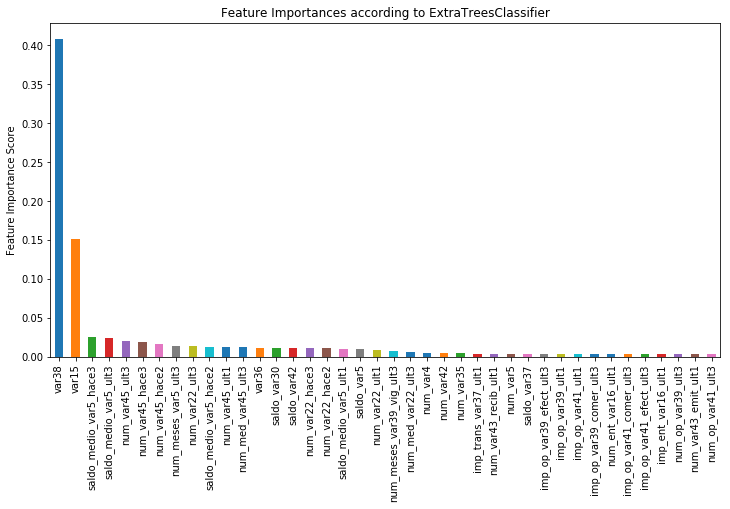

In [14]:
feat_imp = pd.Series(clf.feature_importances_, index = X_new.columns.values).sort_values(ascending=False)
feat_imp[:40].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(12, 8))
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom=0.3)
plt.show()

Selecting features using feature importance 

In [15]:
selection = SelectFromModel(selector, prefit=True)
X_select = selection.transform(X_new)

In [16]:
X_select.shape

(76020, 23)

In [17]:
score = train_xgb(X_select,y,n_estimators=110, max_depth = 4, num_parallel_tree = 2,
          gamma=0.99,min_child_weight=2,subsample = 0.6)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   29.8s finished


In [18]:
print(score.mean())

0.835045081369503


##### Observation:
* Feature selection results in a smaller set of features but the AUC decreases to 0.83504
* So we need to use the features that have variance greater than 50%. 

## Hyper Parameter Tuning

We use the data with features that have variance greater than 50%.
And we Tune parameters like 
* The number of estimators
* The depth of the tree
* Gamma
* Subsample

In [19]:
tuning_parameters = {'n_estimators':range(100,110,5),'max_depth':range(3,5,1)}

clf = GridSearchCV(estimator= xgb.XGBClassifier(
                   nthread=-1, num_parallel_tree = 2, seed=1,min_child_weight=2), 
                   param_grid=tuning_parameters, cv=5, scoring='roc_auc',verbose=3,n_jobs=4)

In [20]:
clf.fit(X_new,y)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  7.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, num_parallel_tree=2,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': range(100, 110, 5), 'max_depth': range(3, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [21]:
clf.best_score_

0.8383368667204385

In [22]:
clf.best_params_

{'max_depth': 4, 'n_estimators': 105}

In [23]:
tuning_parameters = {'gamma':np.linspace(0,2,3)}

clf = GridSearchCV(estimator= xgb.XGBClassifier(max_depth=4,n_estimators=105,subsample = 0.6,
                   nthread=-1, num_parallel_tree = 2, seed=1,min_child_weight=2), 
                   param_grid=tuning_parameters, cv=5, scoring='roc_auc',verbose=3,n_jobs=4)

In [24]:
clf.fit(X_new,y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  8.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=105,
       n_jobs=1, nthread=-1, num_parallel_tree=2,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'gamma': array([0., 1., 2.])}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=3)

In [25]:
clf.best_score_

0.8399977374633631

In [26]:
clf.best_params_

{'gamma': 0.0}

In [27]:
tuning_parameters = {'subsample':np.linspace(0,1,2)}

clf = GridSearchCV(estimator= xgb.XGBClassifier(max_depth=4,n_estimators=105,gamma=0.0,
                   nthread=-1, num_parallel_tree = 2, seed=1,min_child_weight=2), 
                   param_grid=tuning_parameters, cv=5, scoring='roc_auc',verbose=3,n_jobs=4)

In [28]:
clf.fit(X_new,y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  1.9min remaining:   47.8s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=105,
       n_jobs=1, nthread=-1, num_parallel_tree=2,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'subsample': array([0., 1.])}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=3)

In [29]:
clf.best_score_

0.8383368667204385

In [30]:
clf.best_params_

{'subsample': 1.0}

In [31]:
score = train_xgb(X_new,y,n_estimators=110, max_depth = 4, num_parallel_tree = 2,
          gamma=0.0,min_child_weight=2,subsample = 0.6)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.9min finished


In [32]:
print(score.mean())

0.840124663885509


##### Observation:
* By tuning parameters we have increased the AUC from 0.83894 to 0.84012

## Preparing submission file

In [36]:
df_test = pd.read_csv("./test.csv",index_col=0)
test = df_test[X_new.columns]

xgb_model = xgb.XGBClassifier(n_estimators=110,nthread=-1, 
                              max_depth = 4,seed=1,
                              num_parallel_tree=2,gamma=0.0,min_child_weight=2,
                              subsample=0.6)    

xgb_model.fit(X_new,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=110,
       n_jobs=1, nthread=-1, num_parallel_tree=2,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
       subsample=0.6)

In [37]:
y_pred = xgb_model.predict_proba(test)

In [38]:
submission = pd.DataFrame({"ID":test.index, "TARGET":y_pred[:,1]})
submission.to_csv("submission.csv", index=False)

## Conclusion

Looking at all the observations above we can infer to the below point:
* The AUC achived using XGB with cross validation is 0.84012
* The PCA and feature selection does reduce the feature space but results in loss of data and decreases the overall AUC.

## Contributions 

1. Code contributed by me ~ 60% code
2. From other sources ~ 40% code

## Citations

* 0.83 score with 36 features only [Link](https://www.kaggle.com/kobakhit/0-84-score-with-36-features-only)
* XGBoost Parameters [Link](https://xgboost.readthedocs.io/en/latest/parameter.html)
* GridSearchCV [Link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* Kaggle Competition - Santander customer satisfaction [Link](https://www.kaggle.com/c/santander-customer-satisfaction)

## License

<div class="alert alert-block alert-info">
MIT License
<br><br>
Copyright (c) 2019 Ninad Subhedar
<br><br>
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
<br><br>
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
<br><br>
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</div>